In [20]:
import jax
import jax.numpy as jnp
print(jax.devices())
print(jnp.sin(jnp.pi/2))

[CudaDevice(id=0)]
1.0


In [21]:
import numpy as np
import os
import dill
script_dir = os.getcwd()


from sde.SDE_ARFF_lib import (
    SDEARFFTrain,
    NNHyperparameters
)


%load_ext autoreload
%autoreload 2



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [45]:
ex_name = "ex4-3D_spd"

# load true functions
with open(f"true_functions/{ex_name}.pkl", "rb") as f:
    true_functions = dill.load(f)

true_drift = true_functions["drift"]
true_diffusion = true_functions["diffusion"]

# load data
data_name = f"{ex_name}_time0.01_SS0.01_ntraj10000"
training_data = np.load(f"training_data/{data_name}.npz")

n_dimensions = training_data["n_dimensions"]
trajectory_step_size = training_data["step_size"]
xlim = training_data["xlim"]
trajectories = training_data["trajectories"]

print(trajectories.shape)

(10000, 3, 2)


In [46]:
# network parameters
validation_split = 0.1
ARFF_validation_split = 0.1

drift_param = NNHyperparameters(K=2**9, 
                                M_min=20,
                                M_max=100,
                                lambda_reg=2e-3,
                                gamma=1,
                                delta=0.1,
                                name='drift')
diffusion_param = NNHyperparameters(K=drift_param.K,
                               M_min=drift_param.M_min,
                               M_max=drift_param.M_max,
                               lambda_reg=drift_param.lambda_reg,
                               gamma=drift_param.gamma,
                               delta=drift_param.delta,
                               name='diffusion')


In [47]:
random_seed = 1
rng = np.random.default_rng(random_seed)

# subsample data
step_size = 0.01
sampled_trajectories = trajectories[:, :, ::int(step_size/trajectory_step_size)]

x_data = sampled_trajectories[:, :, :-1].reshape(-1, n_dimensions)
y_data = sampled_trajectories[:, :, 1:].reshape(-1, n_dimensions)

step_sizes = np.zeros((x_data.shape[0], 1)) + step_size

print(x_data.shape)

(10000, 3)


drift epoch: 20


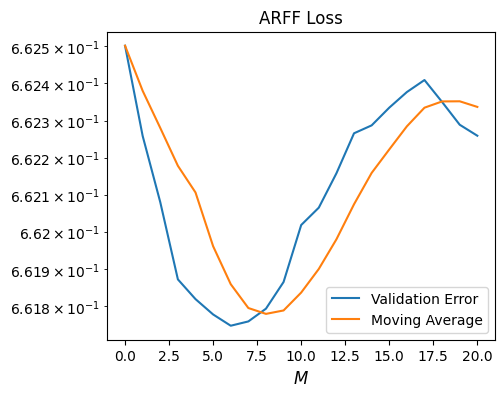

diffusion epoch: 20


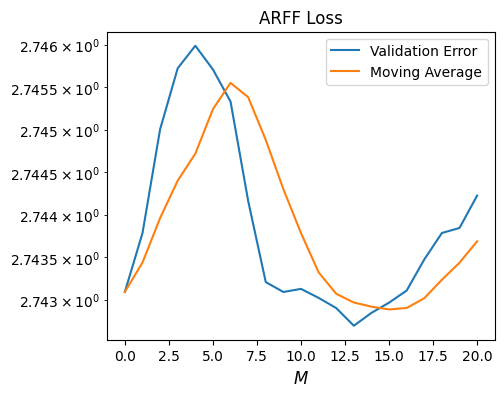

/home/owen/miniconda3/envs/SDE_ARFF_GPU_env/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Drift RMSE: 0.023474199697375298
Diffusion RMSE: (0.001505633583292365-5.0621260072603036e-08j)
Observed loss: None
Observed validation loss: None
True loss: None
Training time: 11.634586572647095


In [48]:
from sde.SDE_ARFF_lib import (
    SDEARFFTrain,
    NNHyperparameters
)

# build network
SAT = SDEARFFTrain(n_dimensions=n_dimensions, diffusion_type="symmetric", random_seed=random_seed, resampling=True)

# train network
hist = SAT.train_model(drift_param, diffusion_param, true_drift, true_diffusion, x_data, y_data, step_sizes=step_sizes, validation_split=validation_split, ARFF_validation_split=ARFF_validation_split, plot=True)


drift epoch: 20


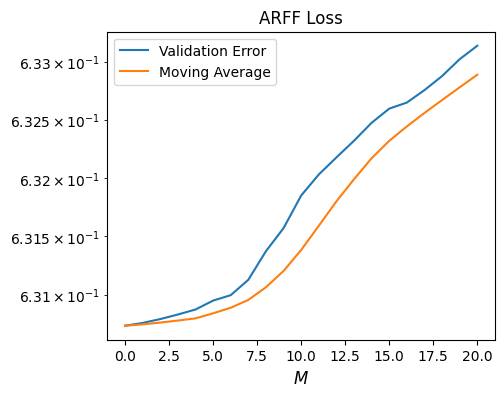

diffusion epoch: 20


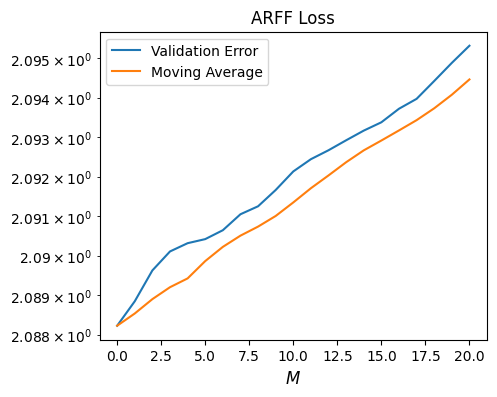

Drift RMSE: 0.012184719555079937
Diffusion RMSE: 0.000788267410825938
Observed loss: -15.5584135055542
Observed validation loss: -15.550553321838379
True loss: -16.147703170776367
Training time: 0.09777522087097168


In [50]:
from sde.SDE_ARFF_JAX_lib import (
    SDEARFFTrain,
    NNHyperparameters
)

# build network
SAT = SDEARFFTrain(n_dimensions=n_dimensions, diffusion_type="symmetric", random_seed=random_seed, resampling=True)

# train network
hist = SAT.train_model(drift_param, diffusion_param, true_drift, true_diffusion, x_data, y_data, step_sizes=step_sizes, validation_split=validation_split, ARFF_validation_split=ARFF_validation_split, plot=True)
